# SC4002 Assignment - Part 3.1, 3.3, & 3.4: Advanced RNNs

**Team 3: Aaron Chen & Javier Tin**

This notebook implements and evaluates four models based on the assignment requirements:

1.  **Part 3.1: Best BiLSTM Baseline:** A BiLSTM model using the optimal hyperparameters (256 hidden dim, 3 layers, 0.6 dropout, 1e-5 weight decay) from `Hyperparameter_tuning.ipynb`.
2.  **Part 3.1: Best BiGRU Baseline:** A BiGRU model using its optimal hyperparameters (512 hidden dim, 2 layers, 0.5 dropout, 1e-6 weight decay) from `Hyperparameter_tuning.ipynb`.
3.  **Part 3.3: Improvement (Attention):** A BiLSTM model augmented with an Attention mechanism.
4.  **Part 3.4: Weak Topic Improvement (Class Weights):** The baseline BiLSTM model trained with a weighted `CrossEntropyLoss`.

All experiments are run with `SEED = 42` for reproducibility. A final summary cell at the end compares the test accuracy of all models.

In [56]:
# === Core PyTorch & System Imports ===
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import sys
import os
import random
import numpy as np

# === Set Random Seed for Reproducibility FIRST ===
# This MUST be done before any other imports (especially data_pipeline)
# to ensure all operations (like data shuffling) are reproducible.
def set_seed(seed):
    """Sets the random seed for full reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # --- NEW/UPDATED LINES ---
    # Force deterministic algorithms
    torch.use_deterministic_algorithms(True) 
    
    # Configure CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 
    
    # Set environment variables
    os.environ['PYTHONHASHSEED'] = str(seed)
    # This is often needed for deterministic bmm/RNNs on GPU
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 
    

SEED = 42
set_seed(SEED)

# === Plotting & Metrics ===
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# === Check PyTorch and CUDA Versions ===
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")

# Add parent directory to path
sys.path.append(os.path.abspath(".."))

# === Data Pipeline Import ===
# Now this import will use the SEED we set above
try:
    from data_pipeline import (
        train_iterator, 
        valid_iterator, 
        test_iterator, 
        TEXT, 
        LABEL, 
        create_embedding_layer,
        device,
        BATCH_SIZE
    )
    print("\n✓ Successfully imported data pipeline.")
    print(f"  - Using device: {device}")
    print(f"  - Batch Size: {BATCH_SIZE}")
except ImportError:
    print("--- ERROR ---")
    print("Could not find 'data_pipeline.py'.")
    print("Please make sure 'data_pipeline.py' is in the same directory as this notebook.")

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.1
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU

✓ Successfully imported data pipeline.
  - Using device: cuda
  - Batch Size: 64


## 2. Helper Functions (Train, Evaluate, Plot, Metrics)

In [57]:
def get_accuracy(preds, y):
    """Calculates multiclass accuracy"""
    top_pred = preds.argmax(1, keepdim=True) # get index of max logit
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train_epoch(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # Set model to training mode
    
    for batch in iterator:
        optimizer.zero_grad()
        
        # Get text and lengths from batch.text tuple
        text, lengths = batch.text
        
        # Forward pass
        predictions = model(text, lengths)
        
        # Calculate loss and accuracy
        loss = criterion(predictions, batch.label)
        acc = get_accuracy(predictions, batch.label)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_epoch(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # Set model to evaluation mode
    
    with torch.no_grad(): # No gradients needed
        for batch in iterator:
            text, lengths = batch.text
            
            # Forward pass
            predictions = model(text, lengths)
            
            # Calculate loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = get_accuracy(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def get_topic_accuracy(model, iterator, criterion, device):
    """Generates a classification report for topic-wise accuracy"""
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            text, lengths = batch.text
            predictions = model(text, lengths)
            
            # Get the predicted class (index with highest probability)
            top_pred = predictions.argmax(1)
            
            all_preds.extend(top_pred.to('cpu').numpy())
            all_labels.extend(batch.label.to('cpu').numpy())
            
    # Get target names from the vocab object
    target_names = [LABEL.vocab.itos[i] for i in range(len(LABEL.vocab))]
    
    return classification_report(all_labels, all_preds, target_names=target_names)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_curves(train_losses, val_losses, train_accs, val_accs, title_prefix=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title(f'{title_prefix} Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot Accuracy
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title(f'{title_prefix} Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

## 3. Model Definitions (Baseline, GRU, & Attention)

Here we define the models we will use.
1.  `BiLSTM_Model`: The baseline model from the original notebook.
2.  `BiGRU_Model`: The baseline GRU model from the original notebook.
3.  `Attention`: A module for the Bahdanau (additive) attention mechanism.
4.  `BiLSTM_Attention_Model`: The improved model for Part 3.3, which uses the `Attention` module.

In [58]:
# === 1. Baseline BiLSTM Model (from original Model.ipynb) ===

class BiLSTM_Model(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = create_embedding_layer(freeze=False)
        
        self.lstm = nn.LSTM(
            input_size=emb_dim, 
            hidden_size=hidden_dim, 
            num_layers=n_layers, 
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0, 
            batch_first=False
        )
        
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.to('cpu'), enforce_sorted=False)
        
        # packed_output is all hidden states
        # hidden is the final hidden state
        # cell is the final cell state
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # Concatenate the final forward (hidden[-2]) and backward (hidden[-1]) hidden states
        last_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        dropped_hidden = self.dropout(last_hidden_state)
        prediction = self.fc(dropped_hidden)
        
        return prediction

# === 2. Baseline BiGRU Model (from original Model.ipynb) ===

class BiGRU_Model(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = create_embedding_layer(freeze=False)
        
        self.gru = nn.GRU(
            input_size=emb_dim, 
            hidden_size=hidden_dim, 
            num_layers=n_layers, 
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=False
        )
        
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.to('cpu'), enforce_sorted=False)
        
        packed_output, hidden = self.gru(packed_embedded)
        
        last_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        dropped_hidden = self.dropout(last_hidden_state)
        prediction = self.fc(dropped_hidden)
        
        return prediction


# === 3. Attention Module (for Part 3.3) ===

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.v = nn.Linear(hidden_dim * 2, 1, bias=False)

    def forward(self, rnn_output, hidden):
        # rnn_output = [seq_len, batch_size, hidden_dim * 2]
        # hidden = [n_layers * 2, batch_size, hidden_dim]
        
        last_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        last_hidden = last_hidden.unsqueeze(1)
        
        rnn_output = rnn_output.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(last_hidden + rnn_output))
        
        attention_scores = self.v(energy).squeeze(2)
        attention_weights = F.softmax(attention_scores, dim=1)
        attention_weights = attention_weights.unsqueeze(1)
        
        context_vector = torch.bmm(attention_weights, rnn_output)
        
        return context_vector.squeeze(1)


# === 4. BiLSTM + Attention Model (for Part 3.3) ===

class BiLSTM_Attention_Model(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = create_embedding_layer(freeze=False)
        
        self.lstm = nn.LSTM(
            input_size=emb_dim, 
            hidden_size=hidden_dim, 
            num_layers=n_layers, 
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=False 
        )
        
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.to('cpu'), enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=False)
        
        context_vector = self.attention(output, hidden)
        
        dropped_context = self.dropout(context_vector)
        prediction = self.fc(dropped_context)
        
        return prediction

## 4. --- Part 3.1, Exp 1: Best Baseline Model (BiLSTM) ---

This section trains the BiLSTM using the optimal hyperparameters from the grid search: 256 hidden dimensions, 3 layers, 0.6 dropout, and 1e-5 weight decay.

In [59]:
# === Hyperparameters ===
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(LABEL.vocab)
EMBEDDING_DIM = create_embedding_layer().embedding_dim
N_EPOCHS = 10 
BIDIRECTIONAL = True

# Best params from grid_search_results_BiLSTM.json
LSTM_HIDDEN_DIM = 256
LSTM_N_LAYERS = 3
LSTM_DROPOUT = 0.6
LSTM_WEIGHT_DECAY = 1e-5

In [60]:
# === Instantiate Baseline BiLSTM ===
model_baseline = BiLSTM_Model(
    INPUT_DIM,
    EMBEDDING_DIM,
    LSTM_HIDDEN_DIM,
    OUTPUT_DIM,
    LSTM_N_LAYERS,
    BIDIRECTIONAL,
    LSTM_DROPOUT
).to(device)

# === Optimizer and Criterion ===
optimizer_baseline = optim.Adam(model_baseline.parameters(), weight_decay=LSTM_WEIGHT_DECAY)
criterion_baseline = nn.CrossEntropyLoss().to(device)

print("✓ BiLSTM Baseline Model, Optimizer, and Criterion initialized.")
print(f"   - Hidden Dim: {LSTM_HIDDEN_DIM}, Layers: {LSTM_N_LAYERS}, Dropout: {LSTM_DROPOUT}, Weight Decay: {LSTM_WEIGHT_DECAY}")
print(f"   - Seed: {SEED}")

✓ BiLSTM Baseline Model, Optimizer, and Criterion initialized.
   - Hidden Dim: 256, Layers: 3, Dropout: 0.6, Weight Decay: 1e-05
   - Seed: 42


In [61]:
# === Training Loop (Baseline BiLSTM) ===

MODEL_SAVE_PATH_BASELINE = 'bilstm-best-baseline.pt'

best_valid_loss = float('inf')
history_baseline = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("--- Starting Baseline BiLSTM Training (Part 3.1) ---")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_baseline, train_iterator, optimizer_baseline, criterion_baseline)
    valid_loss, valid_acc = evaluate_epoch(model_baseline, valid_iterator, criterion_baseline)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Store history
    history_baseline['train_loss'].append(train_loss)
    history_baseline['val_loss'].append(valid_loss)
    history_baseline['train_acc'].append(train_acc)
    history_baseline['val_acc'].append(valid_acc)
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_baseline.state_dict(), MODEL_SAVE_PATH_BASELINE)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("--- Baseline BiLSTM Training Complete ---")

--- Starting Baseline BiLSTM Training (Part 3.1) ---
Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.197 | Train Acc: 52.04%
	 Val. Loss: 0.825 |  Val. Acc: 70.23%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.553 | Train Acc: 80.53%
	 Val. Loss: 0.537 |  Val. Acc: 81.77%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.311 | Train Acc: 90.06%
	 Val. Loss: 0.629 |  Val. Acc: 81.51%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.246 | Train Acc: 92.62%
	 Val. Loss: 0.565 |  Val. Acc: 84.46%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.126 | Train Acc: 96.65%
	 Val. Loss: 0.623 |  Val. Acc: 84.55%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.085 | Train Acc: 97.58%
	 Val. Loss: 0.823 |  Val. Acc: 81.51%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.078 | Train Acc: 97.89%
	 Val. Loss: 0.692 |  Val. Acc: 84.03%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.063 | Train Acc: 98.17%
	 Val. Loss: 0.748 |  Val. Acc: 83.42%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.031 | Train Acc: 99.23%
	 Val. Loss: 0

### Part 3.1(a): Plot curves and report test accuracy (Baseline BiLSTM)

Loss and Accuracy Curves for Baseline BiLSTM (Part 3.1)


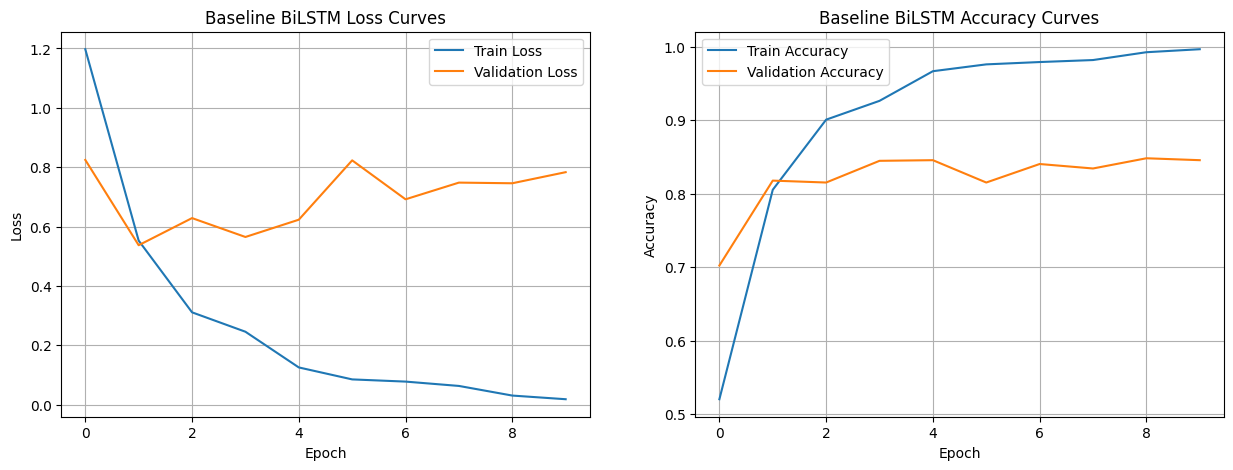


--- Evaluating Baseline BiLSTM on Test Set (Part 3.1) ---
Test Loss: 0.398 | Test Acc: 88.36%


C:\Users\user\AppData\Local\Temp\ipykernel_43708\2242849179.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_baseline.load_state_dict(torch.load(MODEL_SAVE_PATH_BA

In [62]:
# --- Plot Curves (Baseline BiLSTM) ---
print("Loss and Accuracy Curves for Baseline BiLSTM (Part 3.1)")
plot_curves(
    history_baseline['train_loss'], history_baseline['val_loss'],
    history_baseline['train_acc'], history_baseline['val_acc'],
    title_prefix="Baseline BiLSTM"
)

# --- Evaluate on Test Set (Baseline BiLSTM) ---
print("\n--- Evaluating Baseline BiLSTM on Test Set (Part 3.1) ---")

# Load the best performing model
model_baseline.load_state_dict(torch.load(MODEL_SAVE_PATH_BASELINE))

# Store accuracy for final comparison
test_loss_baseline, test_acc_baseline = evaluate_epoch(model_baseline, test_iterator, criterion_baseline)

print(f'Test Loss: {test_loss_baseline:.3f} | Test Acc: {test_acc_baseline*100:.2f}%')

### Part 3.4(d): Get baseline topic-wise accuracy for comparison

In [63]:
print("--- Topic-wise Accuracy for Baseline BiLSTM (for Part 3.4 comparison) ---")
model_baseline.load_state_dict(torch.load(MODEL_SAVE_PATH_BASELINE))
report_baseline = get_topic_accuracy(model_baseline, test_iterator, criterion_baseline, device)
print(report_baseline)

--- Topic-wise Accuracy for Baseline BiLSTM (for Part 3.4 comparison) ---
              precision    recall  f1-score   support

        ENTY       0.89      0.70      0.79        94
         HUM       0.95      0.91      0.93        65
        DESC       0.86      0.98      0.92       138
         NUM       0.92      0.90      0.91       113
         LOC       0.82      0.91      0.87        81
        ABBR       1.00      0.67      0.80         9

    accuracy                           0.88       500
   macro avg       0.91      0.85      0.87       500
weighted avg       0.89      0.88      0.88       500



C:\Users\user\AppData\Local\Temp\ipykernel_43708\3686719692.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_baseline.load_state_dict(torch.load(MODEL_SAVE_PATH_BAS

## 4.5 --- Part 3.1, Exp 2: Best Baseline Model (BiGRU) ---

This section trains the BiGRU using its optimal hyperparameters from the grid search: 512 hidden dimensions, 2 layers, 0.5 dropout, and 1e-6 weight decay.

In [64]:
# === Hyperparameters from Grid Search ===

# Best params from grid_search_results_BiGRU.json
GRU_HIDDEN_DIM = 512
GRU_N_LAYERS = 2
GRU_DROPOUT = 0.5
GRU_WEIGHT_DECAY = 1e-6

# === Instantiate Baseline BiGRU ===
model_gru = BiGRU_Model(
    INPUT_DIM,
    EMBEDDING_DIM,
    GRU_HIDDEN_DIM,
    OUTPUT_DIM,
    GRU_N_LAYERS,
    BIDIRECTIONAL,
    GRU_DROPOUT
).to(device)

# === Optimizer and Criterion ===
optimizer_gru = optim.Adam(model_gru.parameters(), weight_decay=GRU_WEIGHT_DECAY)
criterion_gru = nn.CrossEntropyLoss().to(device)

print("✓ BiGRU Baseline Model, Optimizer, and Criterion initialized.")
print(f"   - Hidden Dim: {GRU_HIDDEN_DIM}, Layers: {GRU_N_LAYERS}, Dropout: {GRU_DROPOUT}, Weight Decay: {GRU_WEIGHT_DECAY}")
print(f"   - Seed: {SEED}")

✓ BiGRU Baseline Model, Optimizer, and Criterion initialized.
   - Hidden Dim: 512, Layers: 2, Dropout: 0.5, Weight Decay: 1e-06
   - Seed: 42


In [65]:
# === Training Loop (Baseline BiGRU) ===

MODEL_SAVE_PATH_GRU = 'bigru-best-baseline.pt'

best_valid_loss = float('inf')
history_gru = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("--- Starting Baseline BiGRU Training (Part 3.1) ---")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_gru, train_iterator, optimizer_gru, criterion_gru)
    valid_loss, valid_acc = evaluate_epoch(model_gru, valid_iterator, criterion_gru)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Store history
    history_gru['train_loss'].append(train_loss)
    history_gru['val_loss'].append(valid_loss)
    history_gru['train_acc'].append(train_acc)
    history_gru['val_acc'].append(valid_acc)
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_gru.state_dict(), MODEL_SAVE_PATH_GRU)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("--- Baseline BiGRU Training Complete ---")

--- Starting Baseline BiGRU Training (Part 3.1) ---
Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.901 | Train Acc: 65.07%
	 Val. Loss: 0.563 |  Val. Acc: 80.03%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.388 | Train Acc: 86.30%
	 Val. Loss: 0.484 |  Val. Acc: 83.85%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.207 | Train Acc: 92.78%
	 Val. Loss: 0.528 |  Val. Acc: 83.42%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.088 | Train Acc: 97.19%
	 Val. Loss: 0.527 |  Val. Acc: 86.11%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.034 | Train Acc: 98.82%
	 Val. Loss: 0.829 |  Val. Acc: 83.07%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.018 | Train Acc: 99.59%
	 Val. Loss: 0.799 |  Val. Acc: 85.42%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.80%
	 Val. Loss: 0.700 |  Val. Acc: 87.07%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.012 | Train Acc: 99.64%
	 Val. Loss: 0.746 |  Val. Acc: 87.59%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.73%
	 Val. Loss: 0.

### Part 3.1(a): Plot curves and report test accuracy (Baseline BiGRU)

Loss and Accuracy Curves for Baseline BiGRU (Part 3.1)


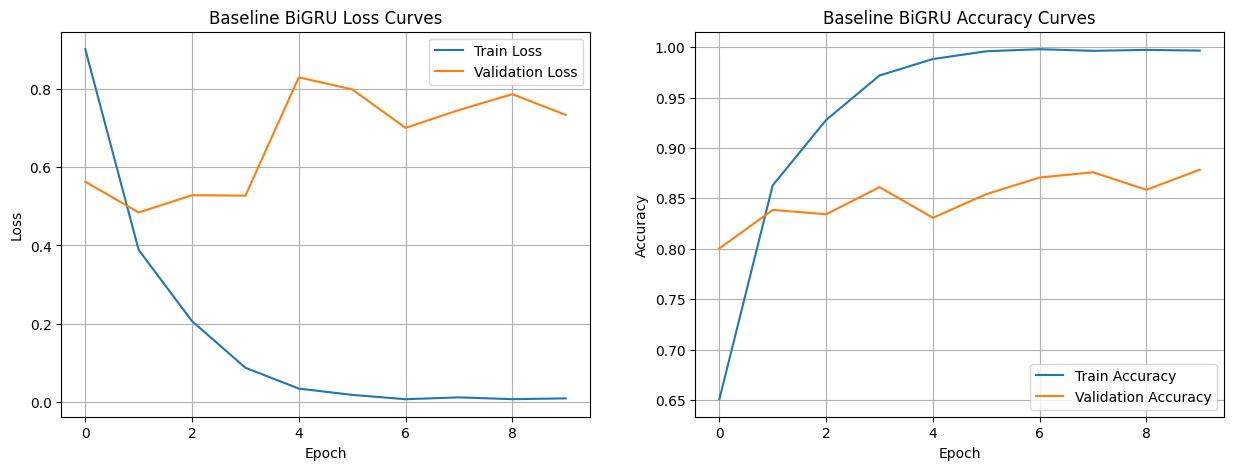


--- Evaluating Baseline BiGRU on Test Set (Part 3.1) ---
Test Loss: 0.336 | Test Acc: 87.92%


C:\Users\user\AppData\Local\Temp\ipykernel_43708\336523091.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_gru.load_state_dict(torch.load(MODEL_SAVE_PATH_GRU))


In [66]:
# --- Plot Curves (Baseline BiGRU) ---
print("Loss and Accuracy Curves for Baseline BiGRU (Part 3.1)")
plot_curves(
    history_gru['train_loss'], history_gru['val_loss'],
    history_gru['train_acc'], history_gru['val_acc'],
    title_prefix="Baseline BiGRU"
)

# --- Evaluate on Test Set (Baseline BiGRU) ---
print("\n--- Evaluating Baseline BiGRU on Test Set (Part 3.1) ---")

# Load the best performing model
model_gru.load_state_dict(torch.load(MODEL_SAVE_PATH_GRU))

# Store accuracy for final comparison
test_loss_gru, test_acc_gru = evaluate_epoch(model_gru, test_iterator, criterion_gru)

print(f'Test Loss: {test_loss_gru:.3f} | Test Acc: {test_acc_gru*100:.2f}%')

## 5. --- Part 3.3: Improvement (BiLSTM + Attention) ---

This section trains the `BiLSTM_Attention_Model` using the optimal BiLSTM hyperparameters from Part 3.1.

In [67]:
# === Instantiate Attention BiLSTM ===
model_attention = BiLSTM_Attention_Model(
    INPUT_DIM,
    EMBEDDING_DIM,
    LSTM_HIDDEN_DIM,
    OUTPUT_DIM,
    LSTM_N_LAYERS,
    BIDIRECTIONAL,
    LSTM_DROPOUT
).to(device)

# === Optimizer and Criterion ===
optimizer_attention = optim.Adam(model_attention.parameters(), weight_decay=LSTM_WEIGHT_DECAY)
criterion_attention = nn.CrossEntropyLoss().to(device)

print("✓ BiLSTM + Attention Model (Part 3.3) initialized.")

✓ BiLSTM + Attention Model (Part 3.3) initialized.


In [68]:
# === Training Loop (Attention BiLSTM) ===

MODEL_SAVE_PATH_ATTN = 'bilstm-attention-model.pt'

best_valid_loss = float('inf')
history_attention = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("--- Starting BiLSTM + Attention Training (Part 3.3) ---")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_attention, train_iterator, optimizer_attention, criterion_attention)
    valid_loss, valid_acc = evaluate_epoch(model_attention, valid_iterator, criterion_attention)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Store history
    history_attention['train_loss'].append(train_loss)
    history_attention['val_loss'].append(valid_loss)
    history_attention['train_acc'].append(train_acc)
    history_attention['val_acc'].append(valid_acc)
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_attention.state_dict(), MODEL_SAVE_PATH_ATTN)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("--- BiLSTM + Attention Training Complete ---")

--- Starting BiLSTM + Attention Training (Part 3.3) ---
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.237 | Train Acc: 49.35%
	 Val. Loss: 0.797 |  Val. Acc: 72.31%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.580 | Train Acc: 79.13%
	 Val. Loss: 0.598 |  Val. Acc: 81.16%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.358 | Train Acc: 88.63%
	 Val. Loss: 0.536 |  Val. Acc: 82.64%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.226 | Train Acc: 93.25%
	 Val. Loss: 0.565 |  Val. Acc: 84.03%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.137 | Train Acc: 96.38%
	 Val. Loss: 0.490 |  Val. Acc: 85.16%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.090 | Train Acc: 97.64%
	 Val. Loss: 0.628 |  Val. Acc: 83.77%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.108 | Train Acc: 97.21%
	 Val. Loss: 0.546 |  Val. Acc: 87.41%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.070 | Train Acc: 98.14%
	 Val. Loss: 0.746 |  Val. Acc: 82.12%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.042 | Train Acc: 98.98%
	 Val. Loss

### Part 3.3(c): Plot curves and report test accuracy (Attention BiLSTM)

Loss and Accuracy Curves for BiLSTM + Attention (Part 3.3)


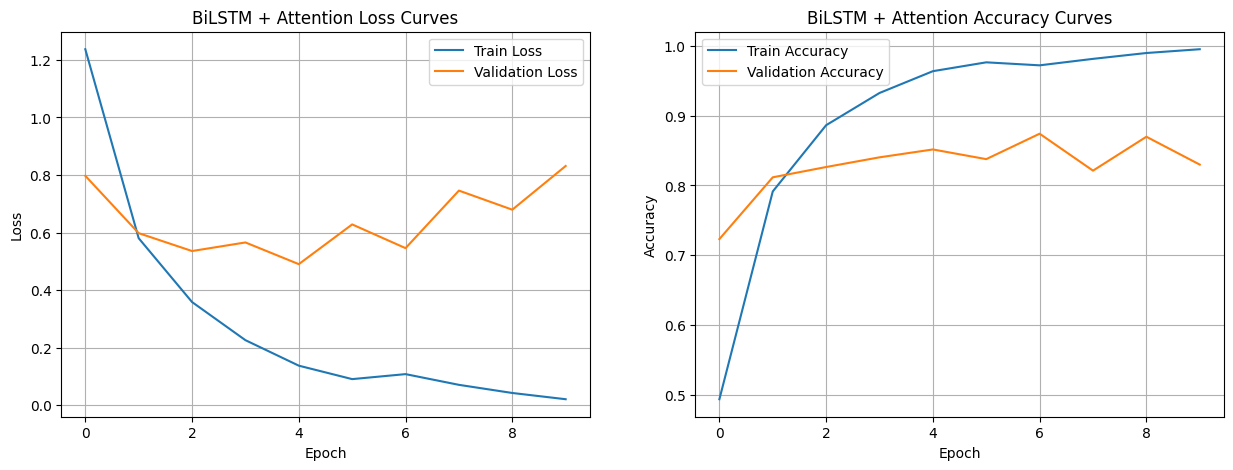


--- Evaluating BiLSTM + Attention on Test Set (Part 3.3) ---
Test Loss: 0.342 | Test Acc: 89.33%


C:\Users\user\AppData\Local\Temp\ipykernel_43708\2541413120.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_attention.load_state_dict(torch.load(MODEL_SAVE_PATH_A

In [69]:
# --- Plot Curves (Attention BiLSTM) ---
print("Loss and Accuracy Curves for BiLSTM + Attention (Part 3.3)")
plot_curves(
    history_attention['train_loss'], history_attention['val_loss'],
    history_attention['train_acc'], history_attention['val_acc'],
    title_prefix="BiLSTM + Attention"
)

# --- Evaluate on Test Set (Attention BiLSTM) ---
print("\n--- Evaluating BiLSTM + Attention on Test Set (Part 3.3) ---")

# Load the best performing model
model_attention.load_state_dict(torch.load(MODEL_SAVE_PATH_ATTN))

# Store accuracy for final comparison
test_loss_attention, test_acc_attention = evaluate_epoch(model_attention, test_iterator, criterion_attention)

print(f'Test Loss: {test_loss_attention:.3f} | Test Acc: {test_acc_attention*100:.2f}%')

## 6. --- Part 3.4: Weak Topic Improvement (Class Weights) ---

This section trains the **baseline BiLSTM model** again, but this time using a `CrossEntropyLoss` with **class weights** to address the class imbalance found in Part 2(e).

In [70]:
# === Calculate Class Weights ===

# 1. Get frequencies from the LABEL vocab
freqs = LABEL.vocab.freqs

# 2. Get labels in the correct index order (from vocab)
labels_in_order = [LABEL.vocab.itos[i] for i in range(len(LABEL.vocab))]
counts = [freqs[label] for label in labels_in_order]

# 3. Calculate weights (inverse frequency)
total_counts = sum(counts)
class_weights = [total_counts / count for count in counts]

# 4. Convert to tensor and send to device
weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"Labels in order: {labels_in_order}")
print(f"Counts per class: {counts}")
print(f"Using class weights: {weights_tensor}")

# === Instantiate Weighted BiLSTM ===
# We use the same baseline model architecture
model_weighted = BiLSTM_Model(
    INPUT_DIM,
    EMBEDDING_DIM,
    LSTM_HIDDEN_DIM,
    OUTPUT_DIM,
    LSTM_N_LAYERS,
    BIDIRECTIONAL,
    LSTM_DROPOUT
).to(device)

# === Optimizer and NEW Criterion with Weights ===
optimizer_weighted = optim.Adam(model_weighted.parameters(), weight_decay=LSTM_WEIGHT_DECAY)
criterion_weighted = nn.CrossEntropyLoss(weight=weights_tensor).to(device)

print("\n✓ BiLSTM Weighted Model (Part 3.4) initialized.")

Labels in order: ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']
Counts per class: [1000, 978, 930, 717, 668, 69]
Using class weights: tensor([ 4.3620,  4.4601,  4.6903,  6.0837,  6.5299, 63.2174], device='cuda:0')

✓ BiLSTM Weighted Model (Part 3.4) initialized.


In [71]:
# === Training Loop (Weighted BiLSTM) ===

MODEL_SAVE_PATH_WEIGHTED = 'bilstm-weighted-model.pt'

best_valid_loss = float('inf')
history_weighted = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("--- Starting BiLSTM + Class Weights Training (Part 3.4) ---")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_weighted, train_iterator, optimizer_weighted, criterion_weighted)
    valid_loss, valid_acc = evaluate_epoch(model_weighted, valid_iterator, criterion_weighted)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Store history
    history_weighted['train_loss'].append(train_loss)
    history_weighted['val_loss'].append(valid_loss)
    history_weighted['train_acc'].append(train_acc)
    history_weighted['val_acc'].append(valid_acc)
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_weighted.state_dict(), MODEL_SAVE_PATH_WEIGHTED)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("--- BiLSTM + Class Weights Training Complete ---")

--- Starting BiLSTM + Class Weights Training (Part 3.4) ---
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.387 | Train Acc: 39.84%
	 Val. Loss: 0.976 |  Val. Acc: 66.58%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 73.99%
	 Val. Loss: 0.686 |  Val. Acc: 78.12%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.368 | Train Acc: 86.04%
	 Val. Loss: 0.630 |  Val. Acc: 78.82%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.236 | Train Acc: 91.08%
	 Val. Loss: 0.726 |  Val. Acc: 86.02%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 94.86%
	 Val. Loss: 0.759 |  Val. Acc: 82.81%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 96.38%
	 Val. Loss: 0.723 |  Val. Acc: 85.07%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.056 | Train Acc: 98.53%
	 Val. Loss: 0.988 |  Val. Acc: 85.59%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.14%
	 Val. Loss: 1.087 |  Val. Acc: 83.59%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.061 | Train Acc: 98.39%
	 Val. 

### Part 3.4(d): Report topic-wise accuracy for the weighted model

Loss and Accuracy Curves for BiLSTM + Class Weights (Part 3.4)


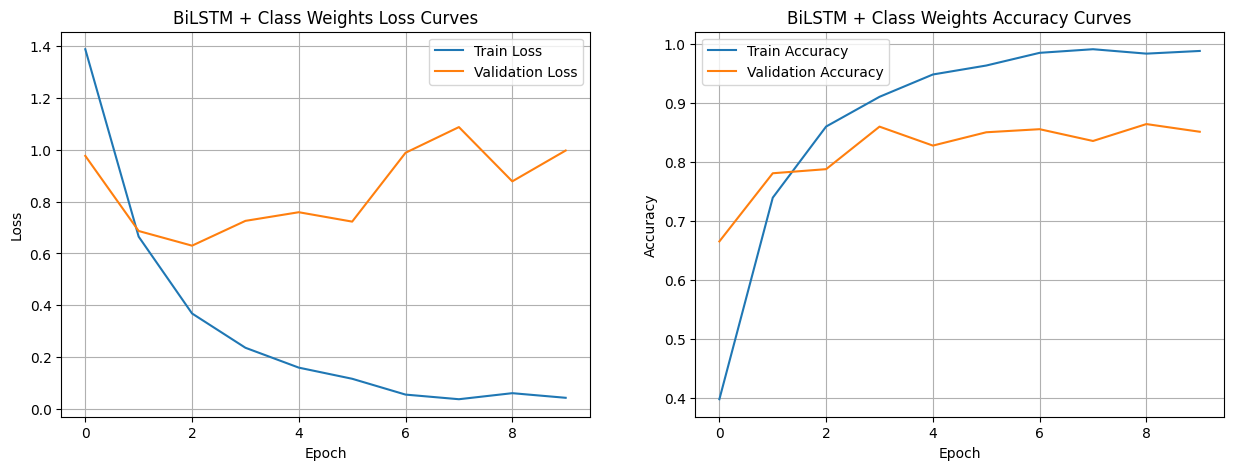


--- Evaluating BiLSTM + Class Weights on Test Set (Part 3.4) ---
Overall Test Loss: 0.439 | Overall Test Acc: 84.66%

--- Topic-wise Accuracy for Weighted BiLSTM (Part 3.4) ---
              precision    recall  f1-score   support

        ENTY       0.87      0.57      0.69        94
         HUM       0.73      0.94      0.82        65
        DESC       0.91      0.90      0.90       138
         NUM       0.96      0.88      0.92       113
         LOC       0.77      0.96      0.86        81
        ABBR       0.54      0.78      0.64         9

    accuracy                           0.85       500
   macro avg       0.80      0.84      0.81       500
weighted avg       0.86      0.85      0.84       500



C:\Users\user\AppData\Local\Temp\ipykernel_43708\2062406316.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weighted.load_state_dict(torch.load(MODEL_SAVE_PATH_WE

In [72]:
# --- Plot Curves (Weighted BiLSTM) ---
print("Loss and Accuracy Curves for BiLSTM + Class Weights (Part 3.4)")
plot_curves(
    history_weighted['train_loss'], history_weighted['val_loss'],
    history_weighted['train_acc'], history_weighted['val_acc'],
    title_prefix="BiLSTM + Class Weights"
)

# --- Evaluate on Test Set (Weighted BiLSTM) ---
print("\n--- Evaluating BiLSTM + Class Weights on Test Set (Part 3.4) ---")
model_weighted.load_state_dict(torch.load(MODEL_SAVE_PATH_WEIGHTED))

# First, show overall accuracy and store it
test_loss_weighted, test_acc_weighted = evaluate_epoch(model_weighted, test_iterator, criterion_weighted)
print(f'Overall Test Loss: {test_loss_weighted:.3f} | Overall Test Acc: {test_acc_weighted*100:.2f}%')

# Then, show the topic-wise report for comparison
print("\n--- Topic-wise Accuracy for Weighted BiLSTM (Part 3.4) ---")
report_weighted = get_topic_accuracy(model_weighted, test_iterator, criterion_weighted, device)
print(report_weighted)

## 7. --- Final Model Comparison ---

This cell summarizes the final test set accuracy for all models trained in this notebook.

In [73]:
# === Final Summary Cell ===

print("==================== FINAL MODEL ACCURACY REPORT ====================")
print(f"NOTE: All models trained with SEED = {SEED}\n")

print("| Model                           | Assignment Part | Test Accuracy |")
print("|---------------------------------|-----------------|---------------|")
print(f"| Best BiLSTM (from Grid Search)  | Part 3.1        | {test_acc_baseline*100:13.2f}% |")
print(f"| Best BiGRU (from Grid Search)   | Part 3.1        | {test_acc_gru*100:13.2f}% |")
print(f"| BiLSTM + Attention              | Part 3.3        | {test_acc_attention*100:13.2f}% |")
print(f"| BiLSTM + Class Weights          | Part 3.4        | {test_acc_weighted*100:13.2f}% |")

print("\n==================== Topic-wise Reports for Part 3.4 ====================")
print("\n--- BASELINE MODEL (for comparison) ---")
print(report_baseline)

print("\n--- WEIGHTED MODEL (for comparison) ---")
print(report_weighted)

# Find and announce the best model
models = {
    'Baseline BiLSTM': test_acc_baseline,
    'Baseline BiGRU': test_acc_gru,
    'BiLSTM + Attention': test_acc_attention
    # We exclude the class weighted model from the "best" calculation,
    # as its goal is to improve weak topics, not overall accuracy.
}

best_model_name = max(models, key=models.get)
best_model_acc = models[best_model_name]

print("\n=========================================================================")
print(f"\n🏆 BEST PERFORMING MODEL (Overall): {best_model_name} (Test Acc: {best_model_acc*100:.2f}%) 🏆")
print("=========================================================================")

==================== FINAL MODEL ACCURACY REPORT ====================
NOTE: All models trained with SEED = 42

| Model                           | Assignment Part | Test Accuracy |
|---------------------------------|-----------------|---------------|
| Best BiLSTM (from Grid Search)  | Part 3.1        |         88.36% |
| Best BiGRU (from Grid Search)   | Part 3.1        |         87.92% |
| BiLSTM + Attention              | Part 3.3        |         89.33% |
| BiLSTM + Class Weights          | Part 3.4        |         84.66% |

==================== Topic-wise Reports for Part 3.4 ====================

--- BASELINE MODEL (for comparison) ---
              precision    recall  f1-score   support

        ENTY       0.89      0.70      0.79        94
         HUM       0.95      0.91      0.93        65
        DESC       0.86      0.98      0.92       138
         NUM       0.92      0.90      0.91       113
         LOC       0.82      0.91      0.87        81
        ABBR       1.00 